# Lab 5
Author: Ksenofontov Gregory

* Model: linear regression with 10 features.
* Hyperparameter: covariance matrix
* Plots: 
  * convergence rate of random search for different ranks.
  * distance from true matrix to the best found

Consider hyperparameter random search problem for given model with different rank of covariance matrix: from 1 to 10. 


## Theory
Semi-defined covariance matrix **A** of normally distributed parameters is a **hyperparameter**

The main idea of experiment: How works random search while alternating rank of hyperparameter from full 10 to 1?

Random search **space** is from 0 to 1 for each element of hyperparameter

## Implementation

Imports and global parameters

In [ ]:
!pip install flax optax distrax

## Imports and constants

In [72]:
import jax.numpy as jnp
from jax import random, value_and_grad, jit

from flax import linen as nn

import optax

import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [73]:
SEED = random.PRNGKey(42)
features = 10
train_size = 25
data_noise = 1

## Supplementary functions

In [115]:
def conv_rate(losses):
    rate = 0
    for i, loss in enumerate(losses[1:]):
        rate += loss / losses[i - 1]
    return rate / (i + 1)

## Generate data

In [110]:
X = jnp.concatenate([random.normal(SEED, shape=(train_size, features - 1)),
                     jnp.ones((train_size, 1))], axis=1)

# A_true - true positive semi-definite covariance matrix
A_true = random.normal(SEED, shape=(features, features))
A_true = jnp.dot(A_true, A_true.T)

# Generate true parameters with A_true
W_true = random.multivariate_normal(SEED, jnp.zeros(features), A_true)

# Generate Y where y_i = f(w, x_i) + ε(x_i) for all i∈(0,train_size)
Y = X @ W_true + data_noise * random.normal(SEED, shape=(train_size, 1))

## Linear model and train function

In [111]:
class LinearRegression:

  def predict(self, W, X):
      """ Realisation of Linear Regression """
      return jnp.dot(X, W)

  def criterion(self, W, X, Y):
      """ Default MSE loss """
      preds = self.predict(W, X)
      return jnp.mean((preds - Y)**2)

linear = LinearRegression()

In [112]:
def train(model, epochs, W, optimizer, verbose=True):
    losses = []
    opt_state = optimizer.init(W)

    @jit
    def step(batch, W, opt_state):
        # Calculate loss and grads
        loss, grads = value_and_grad(model.criterion)(W, batch[0], batch[1])
        # Update params
        updates, opt_state = optimizer.update(grads, opt_state, W)
        W = optax.apply_updates(W, updates)
        return W, opt_state, loss

    for epoch in range(1, epochs + 1):
        avg_loss = 0
        for i, batch in enumerate(zip(X, Y)):
            W, opt_state, loss = step(batch, W, opt_state)
            avg_loss += loss
        losses.append(avg_loss/(i+1))
        if verbose and epoch % 20 == 0: # Print loss every 20 epochs
            print(f"epoch: {epoch}, loss: {avg_loss.mean():.8f}")
    return losses

## Main experiment

In [122]:
lr = 1e-2
epochs = 100
random_search_tries = 20
ranks = features # Ranks to reduce
optimizer = optax.adam(learning_rate=lr)

best_loss = float('inf')
best_hyperparameter = 0
best_rank = 0

conv_rates = []

for rank in reversed(range(1, ranks + 1)):
    avg_conv_rate = 0
    for i in range(random_search_tries):
        # Define hyperparameter
        A = random.normal(random.PRNGKey(i), shape=(features, rank))
        A = jnp.dot(A, A.T)

        # Print A rank
        if i == 0:
          print(f"===== rank {jnp.linalg.matrix_rank(A)} =====")

        # Generate parameters using defined hyperparameter A using SVD method (cholesky decomposition returns NaNs)
        W = random.multivariate_normal(SEED, jnp.zeros(features), A, method='svd')

        # Train model
        losses = train(linear, epochs, W, optimizer, verbose=False)

        # Calculate convergence rate
        avg_conv_rate += conv_rate(losses)
        
        if losses[-1] < best_loss:
            print(f'Best loss improved from {best_loss:.4f} to {losses[-1]:.4f} on try {i + 1}')
            print(f'Distance between A and A_true: {jnp.linalg.norm(A - A_true):.4f}')
            best_rank = rank
            best_loss = losses[-1]
            best_hyperparameter = A

    # Append average convergence rate for given rank        
    conv_rates.append(avg_conv_rate/random_search_tries)
    print(f'~~~~~ convergence rate {conv_rates[-1]:.4f} ~~~~~\n')

===== rank 10 =====
Best loss improved from inf to 82.2792 on try 1
Distance between A and A_true: 36.1660
~~~~~ convergence rate 0.9963 ~~~~~

===== rank 9 =====
~~~~~ convergence rate 0.9966 ~~~~~

===== rank 8 =====
Best loss improved from 82.2792 to 82.2781 on try 15
Distance between A and A_true: 36.5881
~~~~~ convergence rate 0.9966 ~~~~~

===== rank 7 =====
Best loss improved from 82.2781 to 82.2766 on try 2
Distance between A and A_true: 46.2643
Best loss improved from 82.2766 to 82.2756 on try 4
Distance between A and A_true: 34.6203
Best loss improved from 82.2756 to 82.2755 on try 6
Distance between A and A_true: 43.4325
Best loss improved from 82.2755 to 82.2753 on try 16
Distance between A and A_true: 41.5694
~~~~~ convergence rate 0.9967 ~~~~~

===== rank 6 =====
Best loss improved from 82.2753 to 82.2748 on try 10
Distance between A and A_true: 35.1540
~~~~~ convergence rate 0.9968 ~~~~~

===== rank 5 =====
~~~~~ convergence rate 0.9969 ~~~~~

===== rank 4 =====
~~~~~ co

<Axes: >

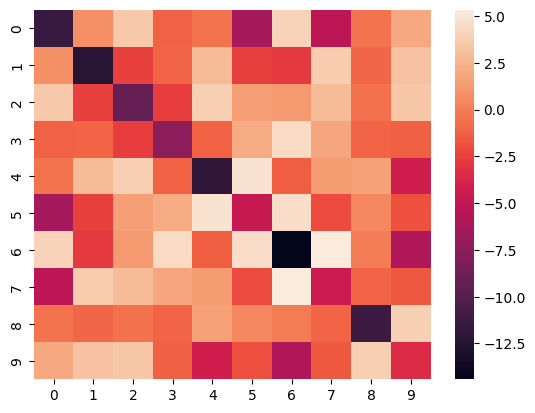

In [124]:
sns.heatmap(A - A_true)